In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test set', 'flower_data', 'cat_to_name.json']


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time

In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../input/flower_data/flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

image_datasets



{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ../input/flower_data/flower_data/train,
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ../input/flower_data/flower_data/valid}

In [18]:
#Loading the data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
trainloaders = dataloaders['train']
testloaders = dataloaders['valid']
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc3600fc8d0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fc3600fcf98>}

In [19]:
trainloaders

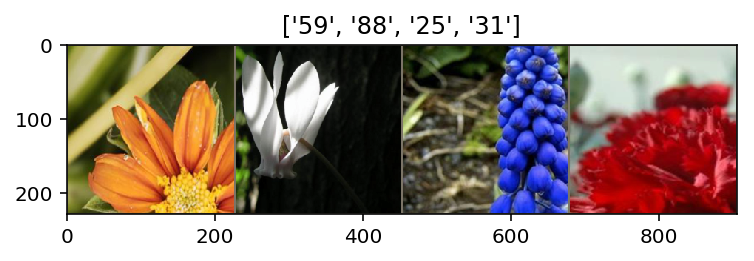

In [20]:
#visualizing the data
class_names = image_datasets['train'].classes
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

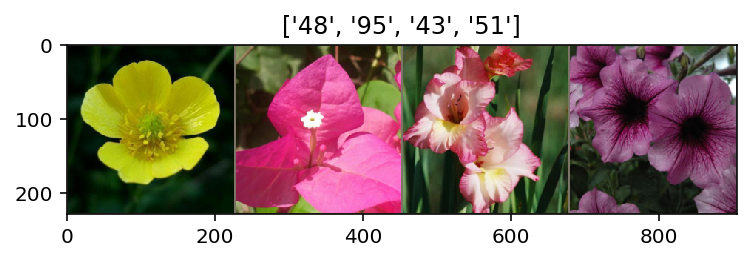

In [21]:
# Get a batch of Validation data
inputs, classes = next(iter(testloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
import json
with open('../input/cat_to_name.json', 'r') as f:
    labelToName = json.load(f)

labelToName


{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
model = models.densenet121(pretrained=True)

In [25]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1),
                                 nn.Linear(128, 102),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [26]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
  
    steps = 0
    running_loss = 0
    for e in range(epochs):
        
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            
            steps += 1
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                
                
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                model.train()


In [27]:
def validation(model, testloader, criterion): 
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        #logps = model.forward(inputs)
        #batch_loss = criterion(logps, labels)
        #test_loss += batch_loss.item()
              # Calculate accuracy
                  #  ps = torch.exp(logps)
                  #  top_p, top_class = ps.topk(1, dim=1)
                  #  equals = top_class == labels.view(*top_class.shape)
                  #  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

       
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equals = (labels.data == ps.max(1)[1])
       #Calculating the accuracy.
        #accuracy += equals.type_as(torch.FloatTensor()).mean()
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    return test_loss, accuracy



In [28]:
train(model, dataloaders['train'], dataloaders['valid'], criterion, optimizer, epochs=10)

validation(model, dataloaders['valid'], criterion)


Epoch: 1/10..  Training Loss: 4.668..  Test Loss: 4.574..  Test Accuracy: 0.041
Epoch: 1/10..  Training Loss: 4.544..  Test Loss: 4.560..  Test Accuracy: 0.029
Epoch: 1/10..  Training Loss: 4.583..  Test Loss: 4.548..  Test Accuracy: 0.034
Epoch: 1/10..  Training Loss: 4.551..  Test Loss: 4.561..  Test Accuracy: 0.034
Epoch: 1/10..  Training Loss: 4.593..  Test Loss: 4.509..  Test Accuracy: 0.034
Epoch: 1/10..  Training Loss: 4.527..  Test Loss: 4.479..  Test Accuracy: 0.034
Epoch: 1/10..  Training Loss: 4.495..  Test Loss: 4.473..  Test Accuracy: 0.034
Epoch: 1/10..  Training Loss: 4.488..  Test Loss: 4.469..  Test Accuracy: 0.022
Epoch: 1/10..  Training Loss: 4.507..  Test Loss: 4.454..  Test Accuracy: 0.035
Epoch: 1/10..  Training Loss: 4.473..  Test Loss: 4.433..  Test Accuracy: 0.023
Epoch: 1/10..  Training Loss: 4.484..  Test Loss: 4.395..  Test Accuracy: 0.028
Epoch: 1/10..  Training Loss: 4.406..  Test Loss: 4.320..  Test Accuracy: 0.050
Epoch: 1/10..  Training Loss: 4.354..  T

Epoch: 3/10..  Training Loss: 2.866..  Test Loss: 2.340..  Test Accuracy: 0.365
Epoch: 3/10..  Training Loss: 3.228..  Test Loss: 2.287..  Test Accuracy: 0.372
Epoch: 3/10..  Training Loss: 3.170..  Test Loss: 2.217..  Test Accuracy: 0.416
Epoch: 3/10..  Training Loss: 3.183..  Test Loss: 2.238..  Test Accuracy: 0.395
Epoch: 3/10..  Training Loss: 3.142..  Test Loss: 2.264..  Test Accuracy: 0.383
Epoch: 3/10..  Training Loss: 3.023..  Test Loss: 2.262..  Test Accuracy: 0.379
Epoch: 3/10..  Training Loss: 3.246..  Test Loss: 2.230..  Test Accuracy: 0.395
Epoch: 3/10..  Training Loss: 3.128..  Test Loss: 2.213..  Test Accuracy: 0.387
Epoch: 3/10..  Training Loss: 3.151..  Test Loss: 2.203..  Test Accuracy: 0.380
Epoch: 3/10..  Training Loss: 3.160..  Test Loss: 2.247..  Test Accuracy: 0.382
Epoch: 3/10..  Training Loss: 3.138..  Test Loss: 2.243..  Test Accuracy: 0.400
Epoch: 3/10..  Training Loss: 2.861..  Test Loss: 2.210..  Test Accuracy: 0.388
Epoch: 3/10..  Training Loss: 3.268..  T

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", 

KeyboardInterrupt: 

In [ ]:
#visualize model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model)
